<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/Class_GAN_20220421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [5]:
generator = keras.Sequential()
generator.add(keras.layers.Dense(7*7*128, input_dim = 100,
                                 activation = keras.layers.LeakyReLU(alpha = 0.2)))

generator.add(keras.layers.BatchNormalization()) #평균은 0 분산은 1이되도록 배치단위로 만들어줌
generator.add(keras.layers.Reshape((7,7,128)))
generator.add(keras.layers.UpSampling2D()) # 좌우로 2배씩 ex > [12/34] [1122/1122/3344/3344] 
generator.add(keras.layers.Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
generator.add(keras.layers.UpSampling2D())
generator.add(keras.layers.Conv2D(1, kernel_size = 5, 
                                  padding = 'same', activation = 'tanh'))

generator.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)      

In [44]:
discriminator = keras.Sequential()
discriminator.add(keras.layers.Conv2D(64, kernel_size = 5, strides = 2,
                  input_shape = (28,28,1), padding = 'same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Conv2D(128, kernel_size = 5, strides =2,
                                      padding = 'same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = 'adam')
discriminator.trainable = False
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_7 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_8 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

In [45]:
ginput = keras.layers.Input(shape = (100,))
dis_output = discriminator(generator(ginput))
gan = keras.models.Model(ginput, dis_output)

gan.compile(loss = 'binary_crossentropy',
            optimizer = 'adam')

gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [53]:
def gan_train(epoch, batch_size, saving_interval):
  (x_train, _),(_,_) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
  x_train = (x_train - 127.5)/127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  d_losses = []
  g_losses = []

  for i in range(epoch):
    # training loss
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    d_loss_real = discriminator.train_on_batch(imgs, true)  # loss 구하기

    #generator loss
    noise = np.random.normal(0,1,(batch_size,100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) #fake에 대한 학습
    
    d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # print('epoch{:d}, d_loss{:%.4f}, g_loss{:.4f}'.format(i,d_loss, g_loss))

    if i % saving_interval == 0:
      noise = np.random.normal(0,1,(25,100))
      gen_images = generator.predict(noise)

      gen_imgs = gen_images * 0.5 + 0.5

      fig, axe = plt.subplots(5,5)
      count = 0
      for j in range(5):
        for k in range(5):
          axe[j,k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
          axe[j,k].axis('off')

          count += 1
      fig.savefig('gan_images/gan_mnist%d.png' % i)  # 집에서 할때는 위치 다시해줘야함
    
  return d_losses, g_losses 


In [11]:
!mkdir gan_images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


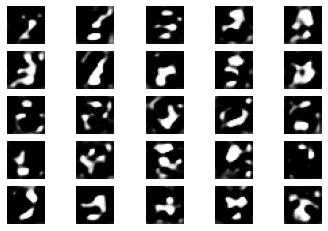

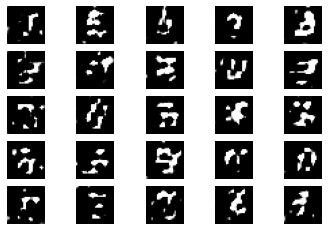

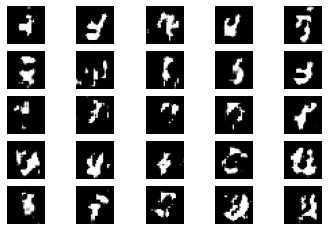

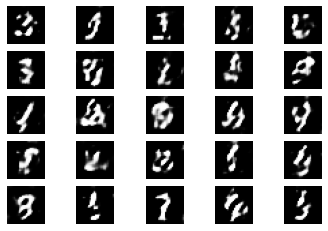

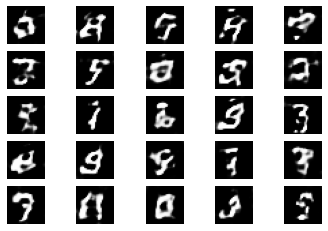

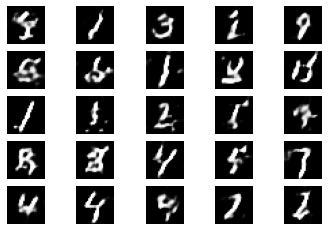

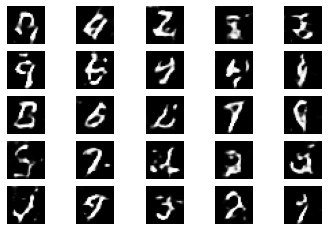

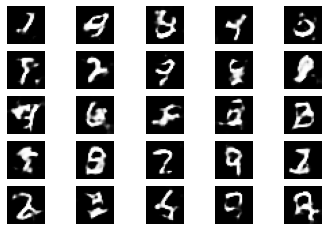

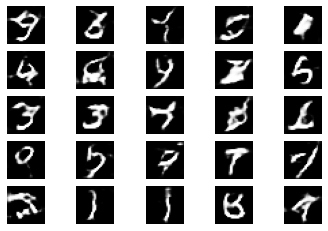

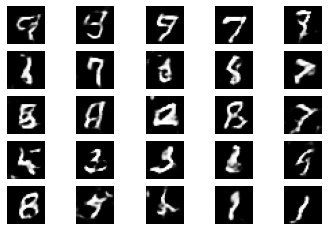

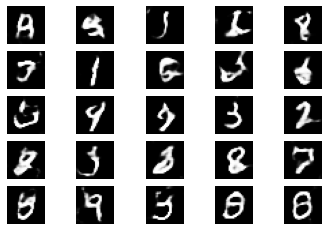

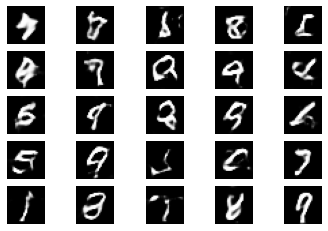

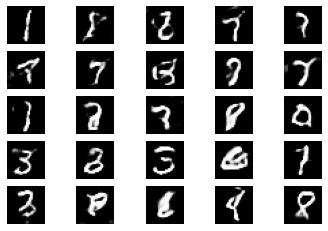

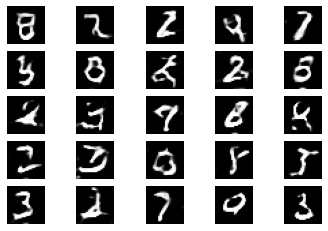

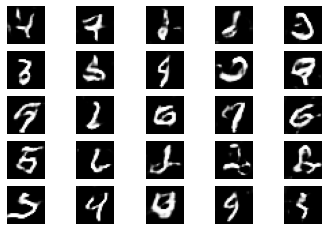

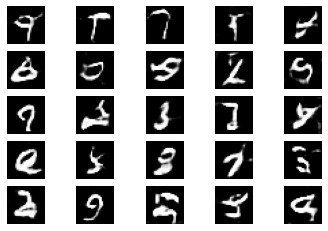

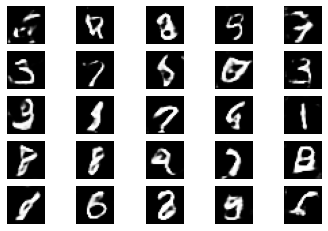

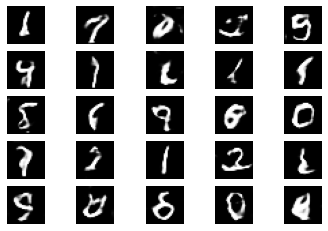

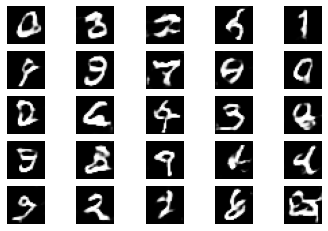

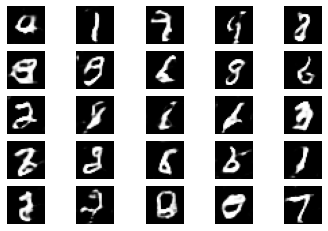

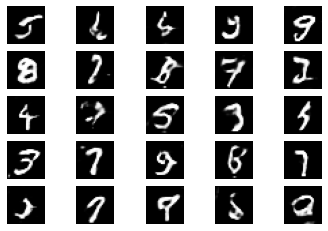

In [54]:
d_loss, g_loss = gan_train(4001, 32, 200)

In [ ]:
## 치매환자의 뇌인지 일반인의 뇌인지 예측하기

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
np.random.seed(3)
tf.random.set_seed(3)



In [57]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./225,
                                                            horizontal_flip = True,
                                                            width_shift_range = 0.1,
                                                            height_shift_range = 0.1,
                                                            rotation_range = 5,
                                                            shear_range = 0.7,
                                                            zoom_range = [0.9,2.2],
                                                            vertical_flip = True,
                                                            fill_mode = 'nearest')

In [62]:
from tensorflow.python.ops.gen_batch_ops import batch
train_generator = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/run_project/train',
    target_size = (150,150),
    save_to_dir = '/content/drive/MyDrive/run_project/gen_train',
    batch_size = 5,
    class_mode = 'binary')

Found 160 images belonging to 2 classes.


In [71]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [63]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./225)

In [64]:
test_generator = test_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/run_project/test',
    save_to_dir = '/content/drive/MyDrive/run_project/gen_test',
    target_size = (150,150),
    batch_size = 5,
    class_mode = 'binary')

Found 120 images belonging to 2 classes.


In [ ]:
## vgg16 google 검색해보기

In [72]:
transfer_model = keras.applications.VGG16(weights = 'imagenet',#대회에서 1등한것 끌어다 사용
                                          include_top = False, #맨마지막단은 우리가 설계
                                          input_shape = (150,150,3)) #보이는건 흑백이지만 파일정보에는 컬러로 되있음
transfer_model.trainable = False #학습하지 않겠다?
transfer_model.summary()                                           

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [73]:
finetune_model = keras.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(keras.layers.Flatten())
finetune_model.add(keras.layers.Dense(64, activation = 'relu'))
finetune_model.add(keras.layers.Dense(1, activation = 'sigmoid'))
finetune_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                524352    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [74]:
finetune_model.compile(loss = 'binary_crossentropy',
                       optimizer = keras.optimizers.Adam(learning_rate = 0.002),
                       metrics = 'accuracy')

In [75]:
#steps_per_epoch = len(X_trian) 160//batch_size (5)
#validation_steps = len(X_test) 120//batch_size (5)#test data

history = finetune_model.fit_generator(
    train_generator, #train 데이터를 사용하겠다
    steps_per_epoch = 10,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
10/10 [==============================] - 20s 2s/step - loss: 0.9583 - accuracy: 0.6200 - val_loss: 0.5978 - val_accuracy: 0.6500
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 0.6059 - accuracy: 0.6600 - val_loss: 0.3476 - val_accuracy: 0.9000
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.5735 - accuracy: 0.7800 - val_loss: 0.6809 - val_accuracy: 0.6500
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.4799 - accuracy: 0.7600 - val_loss: 0.3426 - val_accuracy: 0.9500
Epoch 5/10
10/10 [==============================] - 17s 2s/step - loss: 0.5725 - accuracy: 0.6600 - val_loss: 0.3338 - val_accuracy: 0.8500
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 0.3974 - accuracy: 0.8200 - val_loss: 0.3096 - val_accuracy: 0.8500
Epoch 7/10
10/10 [==============================] - 17s 2s/step - loss: 0.4536 - accuracy: 0.7800 - val_loss: 0.8076 - val_accuracy: 0.5500
Epoch 8/10
10/10 [==

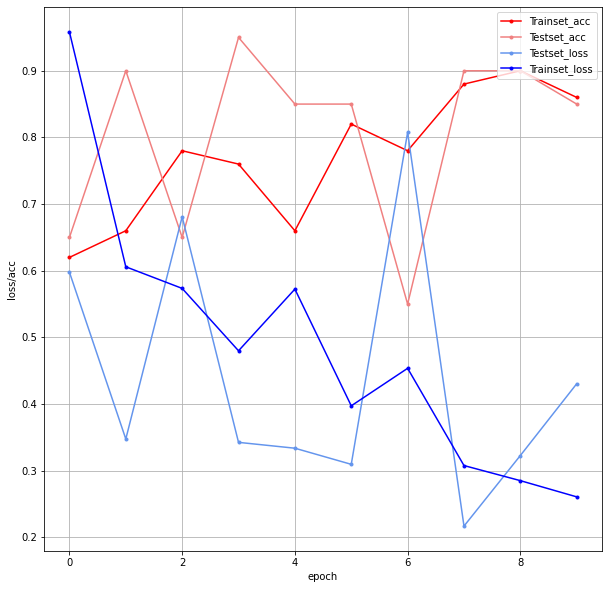

In [79]:
plt.figure(figsize=(10,10))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker = '.', c = 'red', label = 'Trainset_acc')
plt.plot(x_len, val_acc, marker = '.', c = 'lightcoral', label = 'Testset_acc')
plt.plot(x_len, y_vloss, marker = '.', c = 'cornflowerblue', label = 'Testset_loss')
plt.plot(x_len, y_loss, marker = '.', c = 'blue', label = 'Trainset_loss')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()